# Turnover - Ling data

In [1]:
projectdir = joinpath(Base.homedir(), "sciebo/Master/Workspace/Julia_Master/MasterProject_Julia")
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots, BSON
using Distributions, NLsolve, Roots, Random
pyplot()

try
    Turnover
catch e
    include(joinpath(projectdir,"Turnover/src/Turnover.jl"))
    include(joinpath(projectdir,"Turnover/src/test.jl"))
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end
include("experimental_data/lichee_cloneclustering.jl")

include("scripts/distribution_functions.jl")
import TumorGrowth
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\sciebo\Master\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# load Ling data

In [2]:
sanger = TumorGrowth.data_import("experimental_data/Ling/Ling_data_sanger.csv"; delim="\t")
sanger.frequencies = [ones(Float64, length(m)) for m in sanger.mutations];

In [3]:
wes = TumorGrowth.data_import("experimental_data/Ling/Ling_data_wes.csv", delim="\t");

In [4]:
sanger_lichee = TumorGrowth.data_import("experimental_data\\Ling\\Ling_data_sanger_clones_lichee.csv", delim="\t")
lichee_tree = BSON.load("experimental_data\\Ling\\lichee_tree_Sanger.bson")
sanger_lichee.frequencies = map( ones∘length, sanger_lichee.mutations)

sanger_coinc = TumorGrowth.data_import("experimental_data\\Ling\\Ling_data_sanger_clones_coinc.csv", delim="\t")

sanger_coinc.frequencies = map( ones∘length, sanger_coinc.mutations)
;

In [5]:
n = nrow(sanger)
min_samples = 2
N = n^(3/2) * 2/(π^(1/2)*3^(1/4)) / min_samples
println(N)

# turnover_params = ( f_min = 1/20, Nthresh_orph = 95, Nthresh_estr = 95, )
turnover_params = ( f_min = min_samples, Nthresh_orph = N, Nthresh_estr = N, )

freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)
samplecounts = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.reads)

# tumor = deepcopy(sanger_lichee)
tumor = deepcopy(sanger_coinc)
# tumor = deepcopy(sanger);

2062.585878311575


# run turnover inference

In [6]:
Random.seed!(1122)
ds = []
mus = []
Ls = []
@showprogress for L in 0.5:0.1:1.
    for _ in 1:50
        try         
            orphaned_tumor = DataFrame( mutations = unique( 
                    filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
                ))
            orphaned_tumor = TumorGrowth.reduced_mu(orphaned_tumor, L)
            
            estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor.mutations)
                ))
            estranged_tumor = TumorGrowth.reduced_mu(estranged_tumor, L)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> 
                df -> sum( df.isorphaned ) / sum( df.isgreen )
            
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                            N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen )
            
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 4.)
            if 0.001 < d_solve < 0.999 #&& 0.001 < mu_solve < 0.999
                push!( ds, d_solve)
                push!(mus, mu_solve)
                push!(Ls, L)
            end
        catch e
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


## *save & load*

In [4]:
path = joinpath(projectdir, "Turnover", "turnover_data", "Ling_inference_results_coinc.bson")

# SAVE RESULTS

# bson(path, 
#     Dict( "data" => "Ling", "clustering"=>"coinc", "min_samples"=>min_samples, "N"=>N,
#         "ds"=>ds, "mus"=>mus, "subsampling_rate_L"=>Ls)
#     )

# LOAD RESULTS

results = BSON.load(path)
ds, mus, Ls = results["ds"], results["mus"], results["subsampling_rate_L"];

# plot

0.9759913779153895
0.015224681980724741


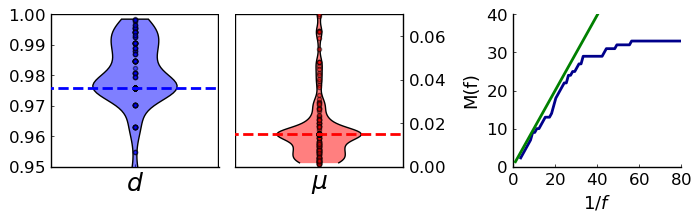

In [7]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.07)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

# mutations = SeqDataFormatting.mfreqs(wes)
# mutations.frequency .= 0
# mutations.purity = ones(nrow(mutations))
# mutations.sample = zeros(Int,nrow(mutations))

# mut2ind = Dict( mutations.mutation .=> 1:nrow(mutations))
# for (n,(row, row_)) in enumerate(zip(eachrow(wes), eachrow(wes_nomigs)))
#     for (m,f) in zip(row.mutations, row.frequencies)
#         i = mut2ind[m]
#         if mutations.frequency[i] < f
#             mutations.frequency[i] = f
#             mutations.purity[i] = row.purity
#             mutations.sample[i] = n
#         end
#     end
# end

# M!(p[end], (mutations.frequency .* mutations.purity) ./ sum(wes.purity), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)

0.9759913779153895
0.015224681980724741


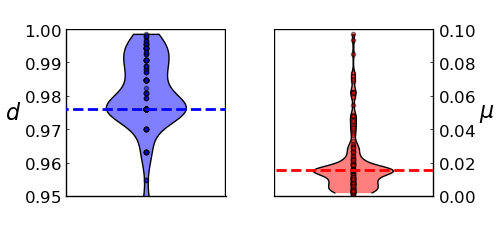

In [43]:
pyplot()
p = plot(layout=(1,2), size=(500,230), legend=:none, grid=false, ytickfontsize=12, margin=6Plots.mm)

ylim = (0.95, 1.0)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, 
    ylim=ylim, xticks=:none)
annotate!(p, [(-0.33, mean(ylim), text(L"d", 16))])
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.1)
yticks = range(ylim..., step=0.02)
plot!(p[2], legend=:none, xlim=xlim, 
    ylim=ylim, yticks=yticks, xticks=:none, ymirror=true)
annotate!(p, [(2.33, mean(ylim), text(L"\mu", 16))])
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

# res = 1/80
# plot!(p[end], tickfontsize=12, labelfontsize=13)
# M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
# plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

# mutations = SeqDataFormatting.mfreqs(wes)
# mutations.frequency .= 0
# mutations.purity = ones(nrow(mutations))
# mutations.sample = zeros(Int,nrow(mutations))

# mut2ind = Dict( mutations.mutation .=> 1:nrow(mutations))
# for (n,(row, row_)) in enumerate(zip(eachrow(wes), eachrow(wes_nomigs)))
#     for (m,f) in zip(row.mutations, row.frequencies)
#         i = mut2ind[m]
#         if mutations.frequency[i] < f
#             mutations.frequency[i] = f
#             mutations.purity[i] = row.purity
#             mutations.sample[i] = n
#         end
#     end
# end

# M!(p[end], (mutations.frequency .* mutations.purity) ./ sum(wes.purity), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, linestyle=:dash)

p

In [36]:
quantile(ds,0.05), median(ds),  quantile(ds,0.95)

(0.8338462491493092, 0.9759913779153895, 0.9955660960907841)

In [37]:
mean(ds), std(ds)/sqrt(length(ds))

(0.9596657880377687, 0.003545007542734653)

In [42]:
name = "Ling_turnover_params"
savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")

0.5: d 0.9906072017368108, mu 0.007939829223820047
0.6: d 0.9541771344049408, mu 0.032455229155325005
0.7: d 0.9784245764015624, mu 0.017389496367223124
0.8: d 0.9759913779153895, mu 0.011487628533056323
0.9: d 0.9759913779153895, mu 0.014443652207195307
1.0: d 0.9759913779153895, mu 0.015224681980724741


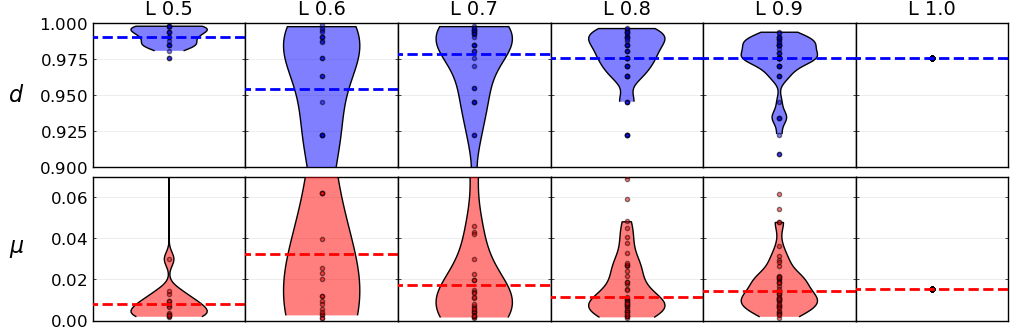

In [30]:
L_unique=unique(Ls)

p = plot(layout=(2,length(L_unique)), size=(length(L_unique)*170, 330), 
    legend=:none, grid=true, ytickfontsize=12, margin=0Plots.mm, xticks=:none, ylabelfontsize=16, yguidefontrotation=-90, framestyle = :box)
annotate!(p[1,1], -.6, .95, (L"d", 16), leftmargin=10Plots.mm,)
annotate!(p[2,1], -.6, .035, (L"\mu", 16), leftmargin=10Plots.mm,)
plot!(p[1,length(L_unique)], rightmargin=3Plots.mm)
plot!(p[2,length(L_unique)], rightmargin=3Plots.mm)

for (i,L) in enumerate(L_unique)
    mask = Ls .== L
    
    ds_, mus_ = ds[[mask]...], mus[[mask]...]
    plot!(p[1,i], title="L $L")

    ylim = (0.9, 1.0)
    xlim = (0.2, 1.8)
    plot!(p[1,i], legend=:none, xlim=xlim, ylim=ylim)
    # hline!(p[1,i], [ylim[2]], c=:black, lw=1.7)
    # vline!(p[1,i], [xlim[2]], c=:black, lw=1.7)
    if L < 1.
        violin!(p[1,i], [1], ds_[ ds_ .> quantile(ds_, 0.1)], c=:blue, fillalpha=0.5)
    elseif L == 1.
        violin!(p[1,i], [1], ds_, c=:blue, fillalpha=0.5)
    end
    scatter!(p[1,i], [1], ds_, c=:blue, alpha=0.5, ms = 3)
    hline!(p[1,i], [median(ds_)], c=:blue, lw=2., style=:dash)
    print(L, ": d ", median(ds_))
    i>1 && plot!(p[1,i],yformatter = y->"")

    xlim = (0.2, 1.8)
    ylim = (0.0, 0.07)
    yticks = range(ylim..., step=0.02)
    plot!(p[2,i], legend=:none, xlim=xlim, ylim=ylim, yticks=yticks)
    # hline!(p[2,i], [ylim[2]], c=:black, lw=1.7)
    # vline!(p[2,i], [xlim[1]], c=:black, lw=1.7)
    if L < 1.
        violin!(p[2,i], [1], mus_[ mus_ .< quantile(mus_, 0.9)], c=:red, fillalpha=0.5)
    elseif L == 1.
        violin!(p[2,i], [1], mus_, c=:red, fillalpha=0.5)
    end
    scatter!(p[2,i], [1], mus_, c=:red, alpha=0.5, ms = 3)
    hline!(p[2,i], [median(mus_)], c=:red, lw=2., style=:dash)
    println(", mu ", median(mus_))
    i>1 && plot!(p[2,i],yformatter = y->"")
end
p

In [31]:
name = "Ling_coinc_subsample"
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")

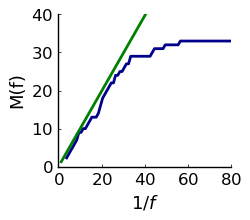

In [13]:
p = plot(layout=(1,1), size=(250,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)
res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

In [10]:
# name = "Ling_coinc_sottoriva"
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".pdf")
# savefig("Turnover\\turnover_plots\\experimental_data\\"* name * ".png")